In [96]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'simulator'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpc_fly import MpcFlyWind

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set desired trajectory

In [97]:
# Set trajectory time
fs = 100  # [hz] sampling frequency
dt = 1 / fs  # [s] sampling time
T = 0.5  # [s] total time
tsim = np.arange(0.0, T + dt/2, step=dt)  # [s] time vector

In [98]:
# Set ambient wind over time
w = 0.4 * np.ones_like(tsim) # [m/s] ambient wind magnitude
zeta = np.pi * np.ones_like(tsim) # [m/s] ambient wind direction

In [99]:
# Set parallel & perpendicular velocities over time
v_para_dot = 1.0  # add some acceleration in parallel direction
v_para = 0.3 * np.ones_like(tsim) + v_para_dot*tsim  # [m/s] parallel velocity
v_perp = 0.0 * np.ones_like(tsim) # [m/s] perpendicular velocity

In [100]:
# Set heading over time
phi = (np.pi/5) * np.ones_like(tsim)  # [rad] default heading
phi[25:] = phi[0] + np.pi/2  # add a turn

# Set fly parameters

In [101]:
# SI units
m = 0.25e-6  # [kg] mass
I = 5.2e-13  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.02369
C_phi = 27.36e-12  # [N*m*s] yaw damping: 10.1242/jeb.038778
C_para = m / 0.170  # [N*s/m] calculate using the mass and time constant reported in 10.1242/jeb.098665
C_perp = C_para  # assume same as C_para

In [102]:
# Convert to units of mg & mm to help with scaling for ODE solver
m = m * 1e6  # [mg]
I = I * 1e6 * (1e3) ** 2  # [mg*mm/s^2 * mm*s^2]
C_phi = C_phi * 1e6 * (1e3) ** 2  # [mg*mm/s^2 *m*s]
C_para = C_para * 1e6  # [mg/s]

In [103]:
# Store in dictionary
x0 = {'m': m, 'I': I, 'C_para': C_para, 'C_perp': C_perp, 'C_phi': C_phi}

# Run MPC

In [104]:
n_horizon = 10  # how many time steps to look ahead during optimization
r_weight = 1e-5  # how much to penalize the control inputs, larger values lead to smoother change in states

In [105]:
# Reconstruct trajectory with MPC
fly_mpc = MpcFlyWind(v_para, v_perp, phi, w, zeta, x0=x0, dt=dt, n_horizon=n_horizon, r_weight=r_weight, run=True)

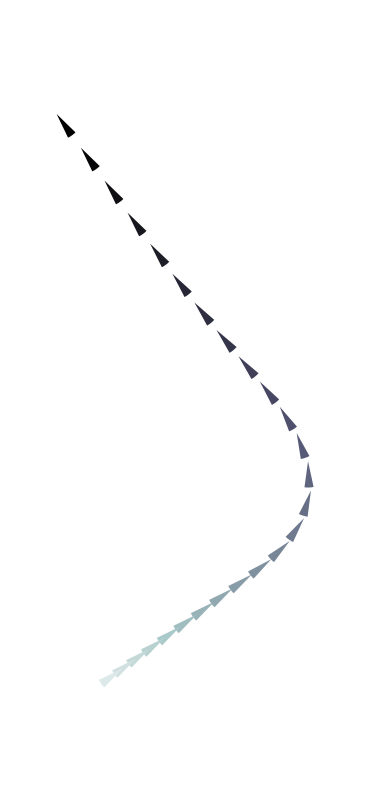

In [106]:
# Plot trajectory
fly_mpc.plot_trajectory(arrow_size=0.01, nskip=1, dpi=200)

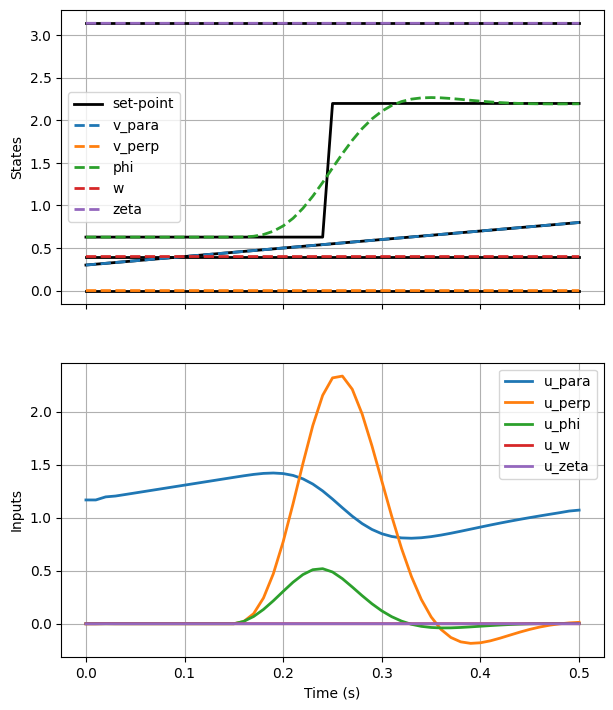

In [107]:
# Plot tracking error
fly_mpc.plot_setpoint_tracking()


In [108]:
# Save all simulation data
sim_data = fly_mpc.sim_data_df.copy()

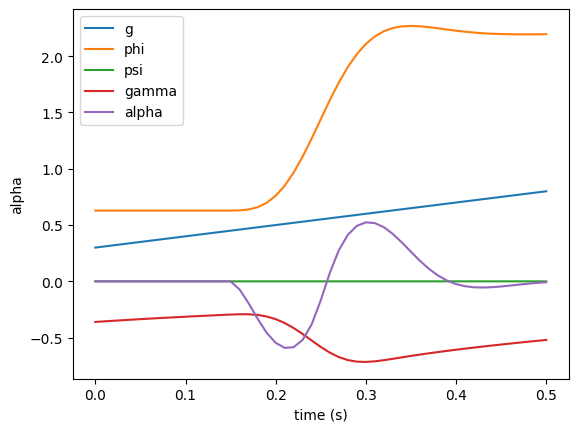

In [109]:
# Plot some other variables
plot_vars = ['g', 'phi', 'psi', 'gamma', 'alpha']

fig, ax = plt.subplots(nrows=1, ncols=1)
for v in plot_vars:
    ax.plot(sim_data.time, sim_data[v], label=v)
    ax.set_ylabel(v)

ax.set_xlabel('time (s)')
ax.legend()
